In [1]:
import dask as da
import dask.dataframe as daskdf
import dask.array as daa
import dask.distributed as dd
import dask.datasets as ds
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import sklearn as sk
import numpy as np
import dask_ml.preprocessing as dm_pre
import dask_ml.cluster as dm_cluster
import dask_geopandas as dg
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from scipy.stats import pearsonr
import time

In [2]:
"""data look like this: ;mapped_veh_id;timestamps_UTC;lat;lon;RS_E_InAirTemp_PC1;RS_E_InAirTemp_PC2;RS_E_OilPress_PC1;RS_E_OilPress_PC2;RS_E_RPM_PC1;RS_E_RPM_PC2;RS_E_WatTemp_PC1;RS_E_WatTemp_PC2;RS_T_OilTemp_PC1;RS_T_OilTemp_PC2
0;181;2023-08-01 03:44:12;50.7698183;3.8721144;27.0;23.0;255.0;238.0;794.0;801.0;83.0;81.0;76.0;77.0
1;143;2023-08-01 06:36:29;51.0399934;3.6934285;33.0;32.0;272.0;324.0;802.0;804.0;78.0;78.0;73.0;74.0
2;183;2023-08-24 06:53:54;50.7422026;3.6020347;31.0;33.0;234.0;182.0;799.0;802.0;82.0;82.0;85.0;87.0"""
# Load data
def load_data():
    print("Loading data...")
    start = time.time()
    df = daskdf.read_csv("ar41_for_ulb.csv", sep=';')
    end = time.time()
    print("Data loaded in {} seconds".format(end-start))
    return df

ddf = load_data()
ddfprepprep = ddf.drop(columns=['Unnamed: 0'])
# convert all temperatures from celcius to kelvin
ddf['RS_E_InAirTemp_PC1'] = ddf['RS_E_InAirTemp_PC1'] + 273.15
ddf['RS_E_InAirTemp_PC2'] = ddf['RS_E_InAirTemp_PC2'] + 273.15
ddf['RS_E_WatTemp_PC1'] = ddf['RS_E_WatTemp_PC1'] + 273.15
ddf['RS_E_WatTemp_PC2'] = ddf['RS_E_WatTemp_PC2'] + 273.15
ddf['RS_T_OilTemp_PC1'] = ddf['RS_T_OilTemp_PC1'] + 273.15
ddf['RS_T_OilTemp_PC2'] = ddf['RS_T_OilTemp_PC2'] + 273.15


Loading data...
Data loaded in 0.03351259231567383 seconds


# Phase 3: Data Preparation
This phase covers constructing the final data set for modeling tools. Steps include selecting data, cleansing data, constructing data, integrating data, and formatting data.

Select Data:

Decide on data based on relevance, quality, and technical constraints.
Explain data inclusions/exclusions and prioritize attributes.
Clean Data:

Ensure data cleanliness, address missing values using appropriate techniques.
Document how quality problems were addressed.
Construct Data:

Develop new records or derived attributes, considering modeling needs.
Example: Create "income per head" as a derived attribute.
Integrate Data:

Combine information from multiple tables or records.
Perform aggregations to summarize information.
Format Data:

Change data format or design to suit modeling tools.
Example: Trim strings, reorganize information.

In [3]:
# Select Data: Filtering out all data before january 2023
def select_data(df):
    ddf = df[df['timestamps_UTC'] >= '2023-01-01']
    # to drop the erratic data and keep only those in 10-90 percentile for every feature
    for col in ddf.columns:
        if col not in ['timestamps_UTC', 'lat', 'lon', 'mapped_veh_id']:
            ddf = ddf[(ddf[col] > ddf[col].quantile(0.0001)) & (ddf[col] < ddf[col].quantile(0.9999))]

    return ddf

ddfprep = select_data(ddf)

# filter out all data out of belgium
def filter_belgium(df):
    ddf = df[(df['lat'] > 50.0) & (df['lat'] < 51.59) & (df['lon'] > 3.2) & (df['lon'] < 5.89)]
    return ddf

ddfprep = filter_belgium(ddfprep)
#index fix 
ddfprep = ddfprep.reset_index(drop=True)



In [4]:
## AS seen in exploratory analysis, we have nan values only for PC2 on 12726 rows over 17M rows so we can drop them
ddfprep = ddfprep.drop_duplicates()
ddfprep = ddfprep.dropna()

#print (len (ddfprep)) 
#print(ddf.head())

## TODO: Construct Data if needed here 

In [5]:
# we will cluster the lan and lon and associate to each row the name of a city centroid of the cluster 
def categorize_city(df):
    conditions = [
        (df['lat'] < 50.522345) & (df['lon'] < 4.586875),  # Charleroi
        (df['lat'] > 50.522345) & (df['lon'] < 4.073960),  # Gent
        ((df['lat'] >= 50.522345) & (df['lat'] <= 51.042345) & (4.073960 <= df['lon']) & (df['lon'] < 4.786476) ),  # Brussels
        ((df['lat'] > 51.042345) & (4.073960 < df['lon']) & (df['lon'] < 4.786476) ), # Antwerp
        ((df['lat'] >= 50.522345) & (4.786476 <= df['lon'])), # Hasselt
    ]
    choices = ['Charleroi', 'Gent', 'Brussels', 'Antwerp', 'Hasselt']
    df['city'] = np.select(conditions, choices, default='Namur')  # Namur as default
    return df

# Apply the function to each partition of the Dask DataFrame
ddfprep = ddfprep.map_partitions(categorize_city)

#ddfprep = ddfprep.drop_duplicates()
#ddfprep = ddfprep.dropna()
# if column unnamed: 0 is present, drop it
if 'Unnamed: 0' in ddfprep.columns:
    ddfprep = ddfprep.drop(columns=['Unnamed: 0'])
    
#print(ddfprep.head())
#print(len(ddfprep))

In [6]:
# Integrate external data 
# here we will join external weather data with our data 
# for that we will perform join over the city and timestamp.

# Load external data
def load_external_data():
    print("Loading external data...")
    start = pd.Timestamp.now()
    df = daskdf.read_csv("weather.csv")
    end = pd.Timestamp.now()
    print("External data loaded in {} seconds".format((end-start).total_seconds()))
    return df

external_df = load_external_data()

# Prepare for merge by creating a 'date' column
ddfprep['date'] = daskdf.to_datetime(daskdf.to_datetime(ddfprep['timestamps_UTC']).dt.date)
#print(ddfprep.head())
external_df['date'] = daskdf.to_datetime(external_df['date'])

# Merge the DataFrames on 'city' and 'date'
merged_df = ddfprep.merge(external_df, on=['city', 'date'], how='left')

# Drop columns that are not needed anymore
columns_to_drop = ['lat', 'lon', 'date', 'city', 'longitude', 'latitude']
merged_df = merged_df.drop(columns=columns_to_drop)

merged_df = merged_df.dropna()
merged_df = merged_df.drop_duplicates()

# index fix
merged_df = merged_df.reset_index(drop=True)
print(merged_df.columns)

# save the preprocessed data
#ddfprep.to_csv('preprocessed_data.csv')

Loading external data...
External data loaded in 0.009246 seconds
Index(['mapped_veh_id', 'timestamps_UTC', 'RS_E_InAirTemp_PC1',
       'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC1', 'RS_E_OilPress_PC2',
       'RS_E_RPM_PC1', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2',
       'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2', 'tempmax', 'tempmin', 'temp'],
      dtype='object')


Dask DataFrame Structure:
              RS_E_InAirTemp_PC1 RS_E_InAirTemp_PC2 RS_E_OilPress_PC1 RS_E_OilPress_PC2 RS_E_RPM_PC1 RS_E_RPM_PC2 RS_E_WatTemp_PC1 RS_E_WatTemp_PC2 RS_T_OilTemp_PC1 RS_T_OilTemp_PC2  tempmax  tempmin     temp
npartitions=1                                                                                                                                                                                                   
                         float64            float64           float64           float64      float64      float64          float64          float64          float64          float64  float64  float64  float64
                             ...                ...               ...               ...          ...          ...              ...              ...              ...              ...      ...      ...      ...
Dask Name: describe-numeric, 199 graph layers


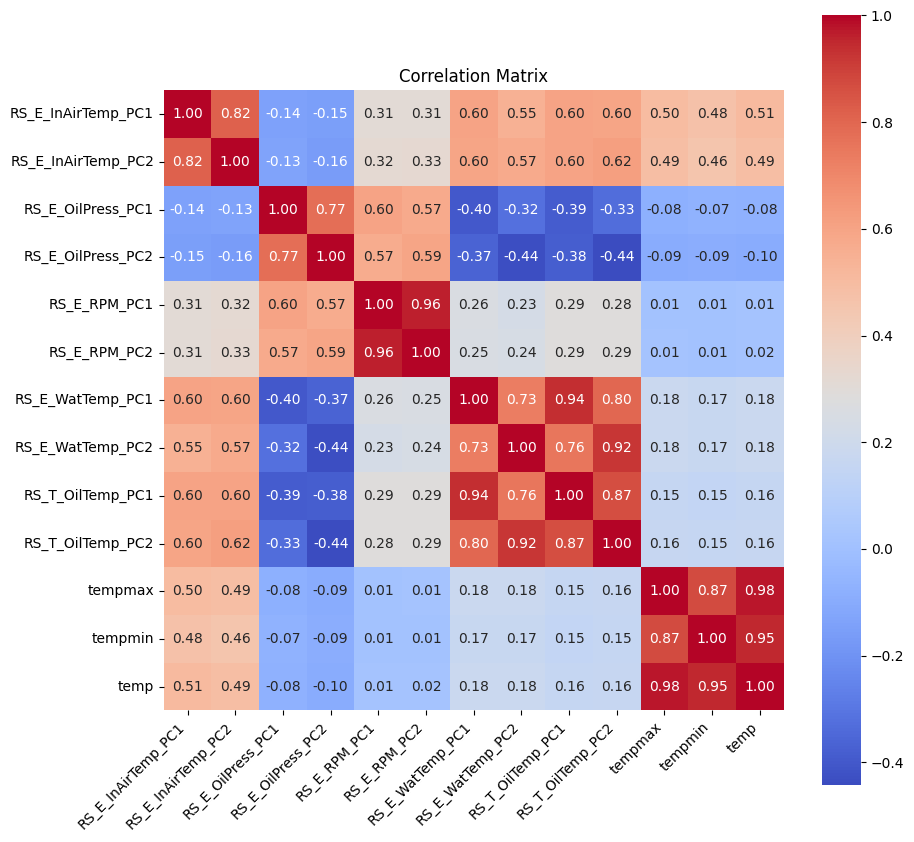

In [9]:
# correlation matrix and statistics of preprocessed data
# for coorelation matrix we will use pearson correlation coefficient 
# for statistics we will use describe function,

# correlation matrix without columns mapped_veh_id and timestamps_UTC
merged = merged_df.drop(columns=['mapped_veh_id', 'timestamps_UTC'])
# statistics of the data
print(merged.describe())

# Sample a subset of the data if it's too large
#sampled_df = merged_df.sample(frac=0.1).compute()  # Adjust the fraction as needed

# Drop columns that are not needed for correlation matrix
#sampled_df = sampled_df.drop(columns=['mapped_veh_id', 'timestamps_UTC'])

# Calculate the correlation matrix on the sampled data
#corr_matrix = sampled_df.corr()
corr_matrix = merged.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
ax.set_xticklabels(corr_matrix.columns, rotation=45, horizontalalignment='right')
ax.set_yticklabels(corr_matrix.columns, rotation=0)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# SAVE THE PREPROCESSED DATA
merged_df.to_csv('preprocessed_data.csv')

